导入需要的库，检查CUDA是否可用，优先选择在GPU上训练，提高训练速度

Skipping incomplete line 6:  1228 (_missing descriptor)

Skipping incomplete line 10:  1232 (_missing descriptor)

Skipping incomplete line 586:  1808 (_missing descriptor)

Skipping image 2099 due to low or high overall brightness.
Skipping image 2100 due to low or high overall brightness.
Skipping image 2101 due to low or high overall brightness.
Skipping image 2102 due to low or high overall brightness.
Skipping image 2103 due to low or high overall brightness.
Skipping image 2104 due to low or high overall brightness.
Skipping image 2105 due to low or high overall brightness.
Skipping image 2106 due to low or high overall brightness.
Skipping image 3283 due to low or high overall brightness.
Skipping image 3860 due to low or high overall brightness.
Skipping image 3861 due to low or high overall brightness.
Skipping image 3862 due to low or high overall brightness.
Skipping image 3883 due to low or high overall brightness.
Skipping incomplete line 834:  4056 (_missing descriptor)



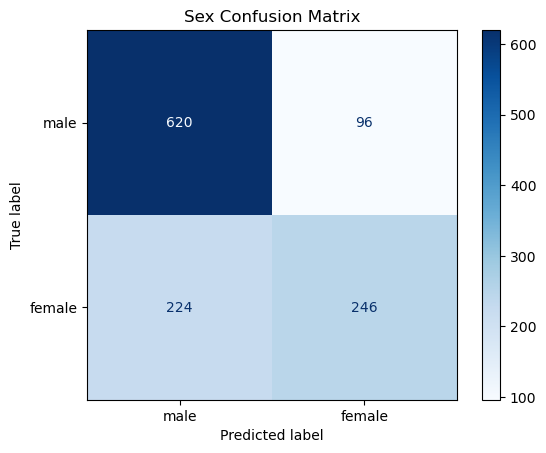

Age Accuracy: 0.79


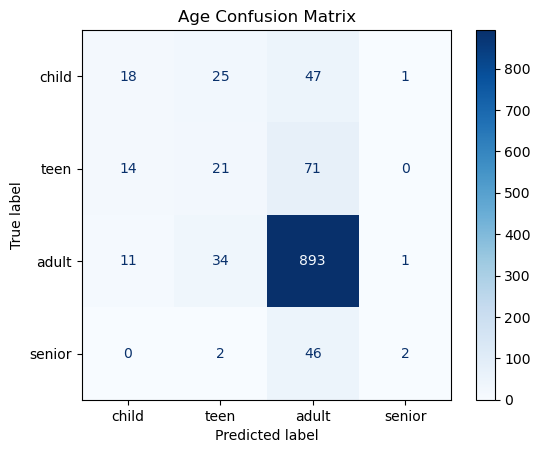

Race Accuracy: 0.93


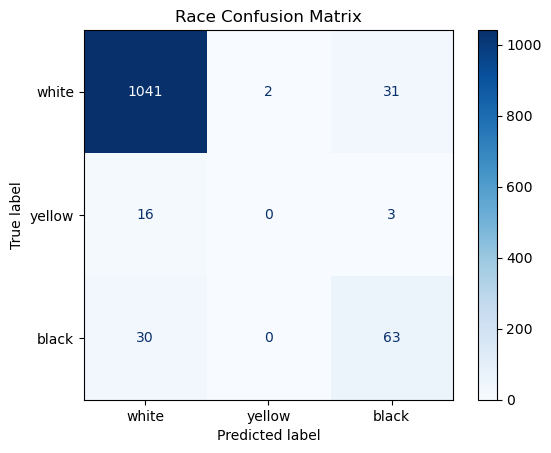

Face Accuracy: 0.56


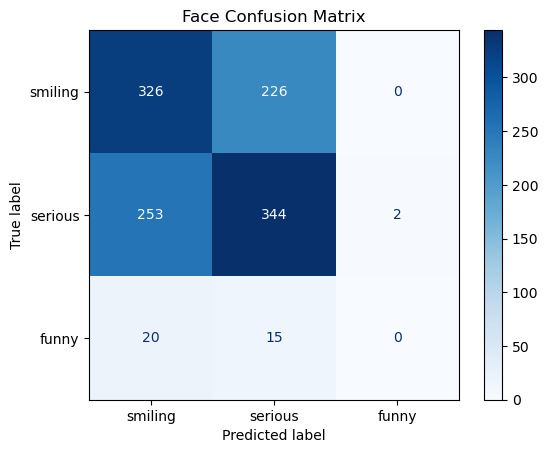

In [3]:
import os
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# 自定义数据集类
class FaceDataset:
    def __init__(self, data_files, raw_data_dir, transform=None, brightness_threshold=0.005, center_brightness_threshold=0.96):
        self.data_files = data_files
        self.raw_data_dir = raw_data_dir
        self.transform = transform
        self.brightness_threshold = brightness_threshold
        self.center_brightness_threshold = center_brightness_threshold
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        for data_file in self.data_files:
            with open(data_file, 'r') as f:
                for line_number, line in enumerate(f, start=1):
                    parts = line.strip().split()
                    if len(parts) < 5:
                        print(f"Skipping incomplete line {line_number}: {line}")
                        continue  # 跳过不完整或错误的数据行

                    try:
                        image_id = parts[0]
                        sex = parts[2].strip('()')
                        age = parts[4].strip('()')
                        race = parts[6].strip('()')
                        face = parts[8].strip('()')

                        # 根据不同大小的文件选择不同的处理方式
                        image_path = os.path.join(self.raw_data_dir, image_id)
                        file_size_kb = os.path.getsize(image_path) / 1024

                        if file_size_kb < 20:
                            with open(image_path, 'rb') as f:
                                img = Image.fromarray(np.reshape(np.frombuffer(f.read(), dtype=np.uint8), (128, 128)))
                        else:
                            with open(image_path, 'rb') as f:
                                img = Image.fromarray(np.reshape(np.frombuffer(f.read(), dtype=np.uint8), (512, 512)))
                                img = img.resize((128, 128))
                        # 检查图片是否接近全黑或全白
                        img_array = np.array(img).astype(float)
                        avg_brightness = np.mean(img_array)
                        if avg_brightness < 255 * self.brightness_threshold or avg_brightness > 255 * (1 - self.brightness_threshold):
                            print(f"Skipping image {image_id} due to low or high overall brightness.")
                            continue  # 跳过过于暗或亮的图片

                        # 检查图片中心区域是否过亮
                        center_region = img_array[48:80, 48:80]  # 中心32x32区域
                        center_avg_brightness = np.mean(center_region)
                        if center_avg_brightness > 255 * self.center_brightness_threshold:
                            print(f"Skipping image {image_id} due to high brightness in the center region.")
                            continue  # 跳过中心区域过亮的图片

                        samples.append((image_id, sex, age, race, face))
                    except IndexError as e:
                        print(f"Skipping malformed line {line_number} due to error: {e}\nLine content: {line}")
                    except Exception as e:
                        print(f"Failed to process image {image_id}: {e}")

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_id, sex, age, race, face = self.samples[idx]
        image_path = os.path.join(self.raw_data_dir, image_id)

        file_size_kb = os.path.getsize(image_path) / 1024

        if file_size_kb < 20:
            with open(image_path, 'rb') as f:
                img = Image.fromarray(np.reshape(np.frombuffer(f.read(), dtype=np.uint8), (128, 128)))
        else:
            with open(image_path, 'rb') as f:
                img = Image.fromarray(np.reshape(np.frombuffer(f.read(), dtype=np.uint8), (512, 512)))
                img = img.resize((128, 128))

        if self.transform:
            img = self.transform(img)

        # 将类别标签转换为整数
        sex_label = {'male': 0, 'female': 1}.get(sex, -1)
        age_label = {'child': 0, 'teen': 1, 'adult': 2, 'senior': 3}.get(age, -1)
        race_label = {'white': 0, 'yellow': 1, 'black': 2, 'hispanic': 0, 'asian': 1, 'other': 0}.get(race, -1)
        face_label = {'smiling': 0, 'serious': 1, 'funny': 2}.get(face, -1)

        labels = [sex_label, age_label, race_label, face_label]
        if any(label == -1 for label in labels):
            print(f"Invalid label in sample: {self.samples[idx]}")
            raise ValueError(f"Invalid label in sample: {self.samples[idx]}")

        return img, labels

# 提取特征函数
def extract_features(image):
    # Convert image to grayscale
    gray_image = np.array(image.convert('L'))

    # Extract color histogram features
    hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256]).flatten()

    # Extract HOG features
    fd, _ = hog(gray_image, orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True)

    # Combine both features
    combined_features = np.concatenate((hist, fd))
    return combined_features

# 数据变换，包括数据增强
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0),
])

test_transform = transforms.Compose([])

# 加载数据集
dataset = FaceDataset(data_files=['face/faceDR', 'face/faceDS'], raw_data_dir='face/rawdata', transform=train_transform)

# 提取特征和标签
features = []
labels = []

for img, lbls in dataset:
    feature = extract_features(img)
    features.append(feature)
    labels.append(lbls)

X = np.array(features)
y_sex = np.array([lbl[0] for lbl in labels])
y_age = np.array([lbl[1] for lbl in labels])
y_race = np.array([lbl[2] for lbl in labels])
y_face = np.array([lbl[3] for lbl in labels])

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train_sex, y_test_sex, y_train_age, y_test_age, y_train_race, y_test_race, y_train_face, y_test_face = train_test_split(
    X_scaled, y_sex, y_age, y_race, y_face, test_size=0.3, random_state=1523)

# 定义KNN分类器
knn = KNeighborsClassifier(n_neighbors=5)
# 绘制混淆矩阵
def plot_confusion_matrix(true_labels, pred_labels, num_classes, class_names, title):
    cm = confusion_matrix(true_labels, pred_labels, labels=list(range(num_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()
# 训练和评估性别分类器
knn.fit(X_train, y_train_sex)
y_pred_sex = knn.predict(X_test)
print(f'Sex Accuracy: {accuracy_score(y_test_sex, y_pred_sex):.2f}')
plot_confusion_matrix(y_test_sex, y_pred_sex, 2, ['male', 'female'], 'Sex Confusion Matrix')

# 训练和评估年龄分类器
knn.fit(X_train, y_train_age)
y_pred_age = knn.predict(X_test)
print(f'Age Accuracy: {accuracy_score(y_test_age, y_pred_age):.2f}')
plot_confusion_matrix(y_test_age, y_pred_age, 4, ['child', 'teen', 'adult', 'senior'], 'Age Confusion Matrix')

# 训练和评估种族分类器
knn.fit(X_train, y_train_race)
y_pred_race = knn.predict(X_test)
print(f'Race Accuracy: {accuracy_score(y_test_race, y_pred_race):.2f}')
plot_confusion_matrix(y_test_race, y_pred_race, 3, ['white', 'yellow', 'black'], 'Race Confusion Matrix')

# 训练和评估表情分类器
knn.fit(X_train, y_train_face)
y_pred_face = knn.predict(X_test)
print(f'Face Accuracy: {accuracy_score(y_test_face, y_pred_face):.2f}')
plot_confusion_matrix(y_test_face, y_pred_face, 3, ['smiling', 'serious', 'funny'], 'Face Confusion Matrix')





